#  Benchmarking class-out-of-distribution performance

In this example we will see how to use our framework to benchmark C-OOD performance.

To use the dataset from our paper (a subset of ImageNet-21k), first download ImageNet-21k in its entirety and use the GetBenchmarkingDataset(path_to_ImageNet21k) to trasnform it into our filtered version of the data.

## The basics

In [2]:
from cood_uncertainty_lib import benchmark_model_on_cood_with_severities
import plotly.express

Using our framework to benchmark a model is as easy as using two lines of code:
```
    results = benchmark_model_on_cood_with_severities(model='resnet50')
    plotly.express.line(results, x='severity_levels', y='cood-auroc', color='model_name-kappa')
```

The above code will benchmark a pretrained ResNet-50 available in the timm repo ( https://github.com/rwightman/pytorch-image-models ) on ImageNet and will plot its "degradation graph" (identical to Figure 1 from the paper).

To save compute, in this example we will benchmark models on a smaller dummy dataset.
To do that, we first need to define our custom dataset that consists of an ID component (in the complete dataset this component is made of classes from ImageNet-1k) and an OOD component (in the complete dataset this component is a filtered version of ImageNet-21k without the classes from ImageNet-1k):

In [3]:
from download_dummy_dataset import download_dummy_dataset
download_dummy_dataset('../test_COOD2')

Dummy dataset was already found in the given directory. Skipping its download.


In [4]:
# <path to images dir>/classname/*.(jpg|png|jpeg)
dummy_ood_dataset_info = {
    'dataset_name': 'Dummy_OOD',
    'images_base_folder': '..\test_COOD2\dummy_ood',  
    'test_estimation_split_percentage': 0.25
}

dummy_id_dataset_info = {
    'dataset_name': 'Dummy_ID',
    'images_base_folder': '..\test_COOD2\dummy_id',
}

The 'dataset_name' value is used for the metadata for the dataset (##note to Mohammed: is this an important argument? why should the user care for it?)

'test_estimation_split_percentage' defines the split between the amount of the OOD data used to estimate each class' severity (hardness) score and the amount used for testing its performance. For ImageNet, we used 25% for testing (50 samples) vs 75% for estimation (150 samples).

Note that you can define your own custom datasets in a similar fashion.

Now let's use our custom dummy dataset and evaluate a pretrained ResNet-18 model with softmax as its confidence function:

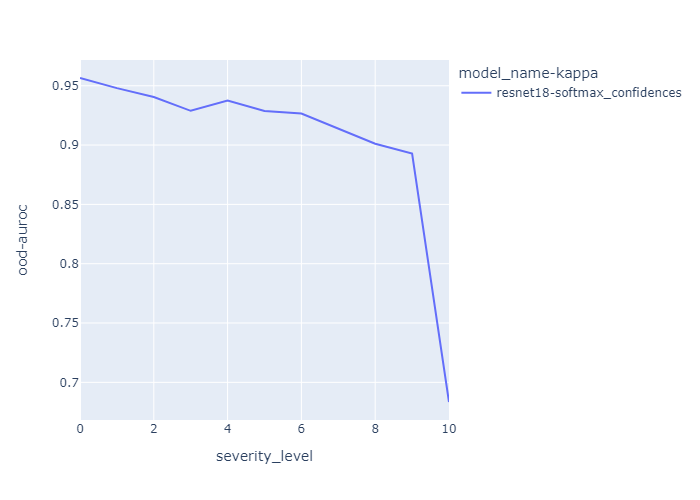

In [11]:
results = benchmark_model_on_cood_with_severities(model='resnet18',
                                                    confidence_metric='softmax',
                                                    cood_dataset_info=dummy_ood_dataset_info,
                                                    id_dataset_info=dummy_id_dataset_info)
fig = plotly.express.line(results, x='severity_level', y='ood-auroc', color='model_name-kappa')
fig.show('png')
# Unfortunately, github doesn't load plotly plots on notebooks. This is why we show them as png files.

The above plot is a 'degradation graph', showing the model's performance in AUROC (y axis) across different severity levels (x axis).

Note that after running this code snippet, a new results csv was added at .\models_results\resnet18\resnet18_softmax_n11.csv 

- The code first checks whether or not results for this specific combination of *(model, confidence function)* already exist.

We can also evaluate and compare different models at the same time.
For example, suppose we want to compare two models, ResNet-18 and ResNet-34, each equipped with either softmax or entropy as its confidence function.

In this case, we can pass lists containing the models and lists containing the confidence functions (instead of just passing one string), as follows:

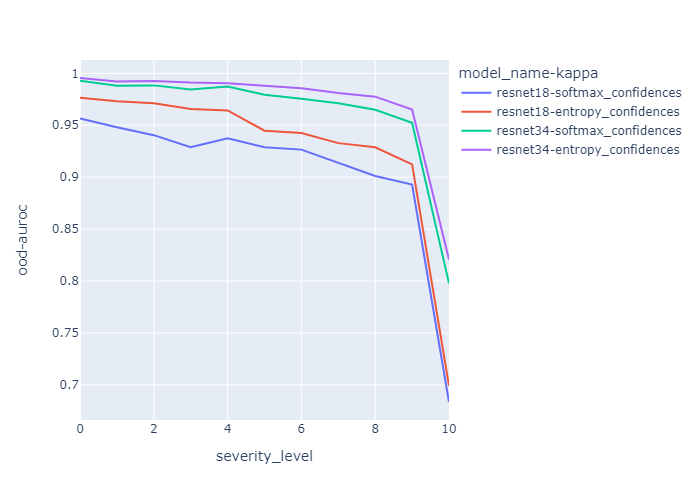

In [12]:
results = benchmark_model_on_cood_with_severities(model=['resnet18', 'resnet34'],
                                                    confidence_metric=['softmax', 'entropy'],
                                                    cood_dataset_info=dummy_ood_dataset_info,
                                                    id_dataset_info=dummy_id_dataset_info)
fig = plotly.express.line(results, x='severity_level', y='ood-auroc', color='model_name-kappa')
fig.show('png')

Note that since we've already evaluated ResNet-18 with a softmax confidence function before, the same results were used for this current comparison rather than being calculated again.

## Evaluating custom models and confidence functions

**Evaluating custom models:**
There are a number of ways to pass the model to the *benchmark_model_on_cood_with_severities* method.
- If it is a 'timm' model, its matching string name could be passed (as seen in the examples above).
- Otherwise, the method expects a dictionary like the one in the example below:

In [9]:
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from utils.misc import get_open_img_transforms, tvtf

weights = MobileNet_V3_Small_Weights.DEFAULT
transforms = weights.transforms()
open_img_transforms = tvtf.Compose(
        [get_open_img_transforms(), transforms])

model = mobilenet_v3_small(weights)

example_model_input = {'model_name': 'mobilenet_v3_small', 'model': model, 'transforms': transforms}
results = benchmark_model_on_cood_with_severities(model=example_model_input,
                                                    confidence_metric='softmax',
                                                    cood_dataset_info=dummy_ood_dataset_info,
                                                    id_dataset_info=dummy_id_dataset_info)
fig = plotly.express.line(results, x='severity_level', y='ood-auroc', color='model_name-kappa')
fig.show('png')

C:\anaconda3\lib\site-packages\torchvision\models\_utils.py:136: UserWarning:

Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.



RuntimeError: Unknown model (mobilenet_v3_small)

The *'model_name'* argument defines the name for the directory into which the results will be saved in ./models_results

**Evaluating custom confidence functions:**
We've implemented the following confidence functions in utils/confidence_functions.py:
- Softmax response
- Entropy
- Max logit
- ODIN
- MC Dropout

Additional confidence functions could be defined and passed as an argument for *'benchmark_model_on_cood_with_severities'*. In the following code snippet we use *'extract_softmax_on_dataset'* as an example for a possible confidence function to be defined:

In [15]:
from utils.confidence_functions import extract_softmax_on_dataset
custom_confidence_function = {'confidence_metric_name': 'softmax_response', 
                              'confidence_metric_callable': extract_softmax_on_dataset}
results = benchmark_model_on_cood_with_severities(model='resnet18',
                                                    confidence_metric=custom_confidence_function,
                                                    cood_dataset_info=dummy_ood_dataset_info,
                                                    id_dataset_info=dummy_id_dataset_info)
fig = plotly.express.line(results, x='severity_level', y='ood-auroc', color='model_name-kappa')
fig.show('png')

AssertionError: model needs to be either a string or nn.Module instance or a dictionary with keys 'model_name'(string) or 'nn.Module' (nn.Module)

## Advanced tricks

**Evaluating specific severity levels:** If we want to make a similar comparison but we're only interested in specific severity levels, for example, 8-10, we can pass the desired levels as an argument to the method:

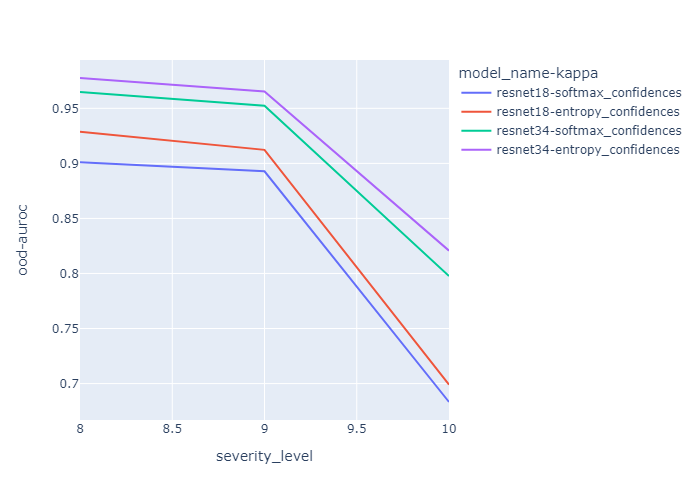

In [13]:
results = benchmark_model_on_cood_with_severities(model=['resnet18', 'resnet34'],
                                                    confidence_metric=['softmax', 'entropy'],
                                                    cood_dataset_info=dummy_ood_dataset_info,
                                                    id_dataset_info=dummy_id_dataset_info,
                                                    levels_to_benchmark=[8,9,10])
fig = plotly.express.line(results, x='severity_level', y='ood-auroc', color='model_name-kappa')
fig.show('png')

**Evaluating a custom number of severity levels:**
In the paper we have used 11 severity levels for analysis, but we can define less \ more levels to be used. This is done using the 'num_severity_levels' argument: 

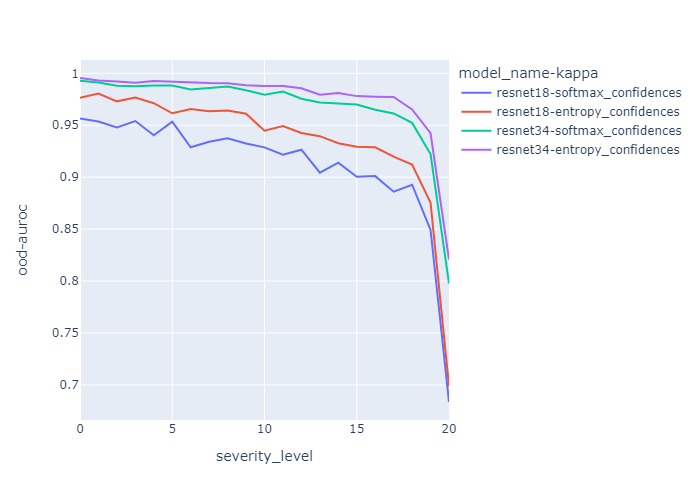

In [14]:
results = benchmark_model_on_cood_with_severities(model=['resnet18', 'resnet34'],
                                                    confidence_metric=['softmax', 'entropy'],
                                                    cood_dataset_info=dummy_ood_dataset_info,
                                                    id_dataset_info=dummy_id_dataset_info,
                                                    num_severity_levels=21)
fig = plotly.express.line(results, x='severity_level', y='ood-auroc', color='model_name-kappa')
fig.show('png')